## imports

In [21]:
import sys
import os
import h5py
import mattplotlib

# setup paths
iteration = 1 # which version of this tutorial to run (in case want results in different dirs)
NBname = 'color_cloud_initial{}'.format(iteration)

myhost = os.uname()[1] # get name of machine
print("Running on Computer: [%s]" %myhost)

datadir = './Mdata/'
dirname = './Monocular/' # Working directory 

import numpy as np
import scipy.io as sio
from copy import deepcopy

# plotting
import matplotlib.pyplot as plt
import mattplotlib as m
import mattrics as met

# Import torch
import torch
from torch import nn

# NDN tools
import NDNT.utils as utils # some other utilities
from NDNT.utils import imagesc   # because I'm lazy
from NDNT.utils import ss        # because I'm real lazy
import NDNT.NDNT as NDN
from NDNT.modules.layers import *
from NDNT.networks import *
from importlib import reload
from time import time
import dill # more comprehensive pickle

from NTdatasets.generic import GenericDataset
from NTdatasets.cumming.binocular import binocular_single

device = torch.device("cuda:1")
dtype = torch.float32

# Where saved models and checkpoints go -- this is to be automated
print( 'Save_dir =', dirname)

# Lazy stuff
from NDNT.utils.DanUtils import ss
from NDNT.utils.DanUtils import imagesc

%load_ext autoreload
%autoreload 2

Running on Computer: [beast]
Save_dir = ./Monocular/
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading expt04
  Time embedding...
11 cells, 362504 time steps.


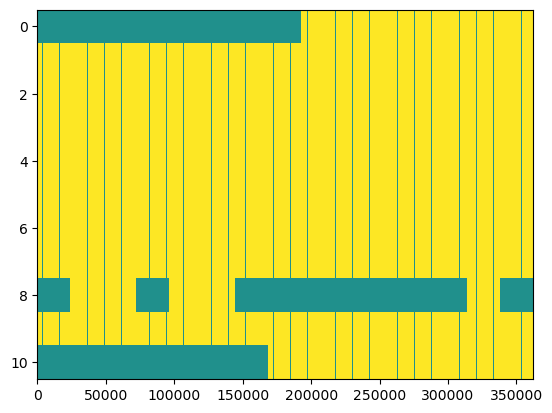

In [5]:
# Load Data
num_lags = 10
expts = ['expt04']
# this can handle multiple experiments
#expts = ['expt04', 'expt05']

from NTdatasets.cumming.monocular import MultiDataset
data = MultiDataset(
    datadir=datadir, filenames=expts, include_MUs=False,
    time_embed=True, num_lags=num_lags )
imagesc(data.dfs.detach().numpy())
print("%d cells, %d time steps."%(data.NC, data.NT))

## NIM

In [6]:
# jump right to shared models
adam_pars = utils.create_optimizer_params(
    optimizer_type='AdamW', batch_size=2000, num_workers=0,
    learning_rate=0.01, early_stopping_patience=4,
    optimize_graph=False, weight_decay = 0.1)
adam_pars['device'] = device

In [7]:
## Shared NIM
num_subs = 11
XTreg0 = 0.1
L1reg0 = 0.0001
Greg = 0.001

# subunit layer
sub_par = NDNLayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, norm_type=1,
    NLtype='relu', bias=False, initialize_center = True)
sub_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'localx':0.001, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC, norm_type=0,
    NLtype='softplus', bias=True, initialize_center = True)

nim_all = NDN.NDN( layer_list=[sub_par, readout_par] )
nim_all.fit(data, **adam_pars, verbose=2)
LLs1 = nim_all.eval_models(data[data.val_inds], null_adjusted=True)
print(LLs1, np.mean(LLs1))

Model: M011_NN

GPU Available: True, GPU Used: True


Validating ver=6: 100%|███████████████████████████████████████████████████| 35/35 [00:01<00:00, 21.25it/s, val_loss=4.52]


Early stopping
Done fitting
  Fit complete: 254.34416341781616 sec elapsed
[ 0.5330398   0.5477184   1.1707644   0.27253592  0.45220053  0.07700944
  0.14402735  0.28495765 -0.00376701  0.51711845  0.23360395] 0.38447353


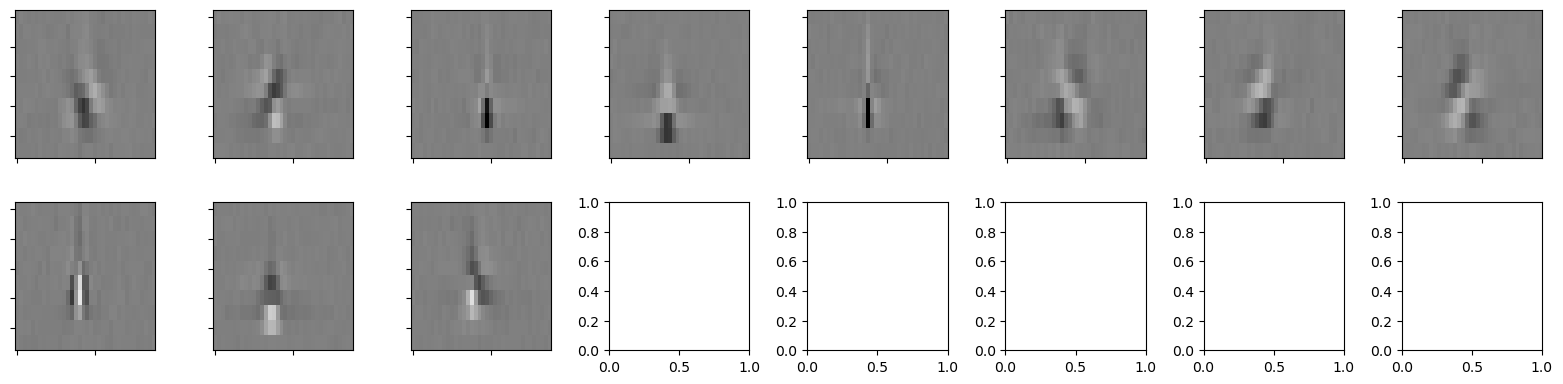

In [8]:
nim_all.plot_filters()

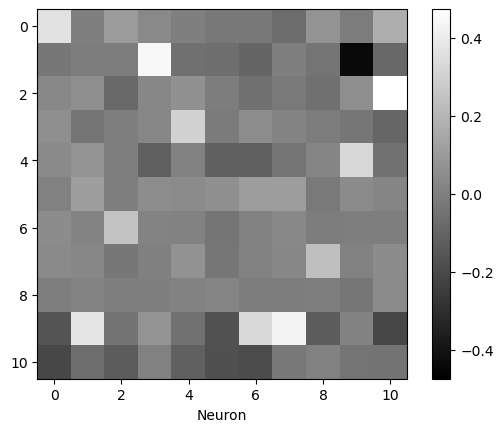

In [9]:
# Readout layer
wR = nim_all.get_weights(layer_target=1)
imagesc(wR, cmap='gray')
plt.xlabel('Subunit')
plt.xlabel('Neuron')
plt.colorbar()
plt.show()

In [10]:
## If there is enough memory on the device, can put the whole dataloader on the GPU
#del train_ds , val_ds
torch.cuda.empty_cache()

data.set_cells()
train_ds = GenericDataset(data[data.train_inds], device=device)
val_ds = GenericDataset(data[data.val_inds], device=device)

  Reset cells_out to full dataset (11 cells).


In [11]:
## About 2x speedup
nim_all = NDN.NDN( layer_list=[sub_par, readout_par])
nim_all.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
LLs1 = nim_all.eval_models(val_ds, null_adjusted=True)
print(LLs1, np.mean(LLs1))


GPU Available: True, GPU Used: True


Validating ver=7: 100%|███████████████████████████████████████████████████| 35/35 [00:00<00:00, 67.31it/s, val_loss=0.43]


Early stopping
Done fitting
  Fit complete: 98.38237857818604 sec elapsed


Eval models: 100%|██████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 139.23it/s]

[ 0.5282929   0.5377948   1.0621192   0.25477898  0.38174248 -0.00737143
  0.04663265 -0.0664115  -0.09713602  0.36019015  0.25659966] 0.29611203


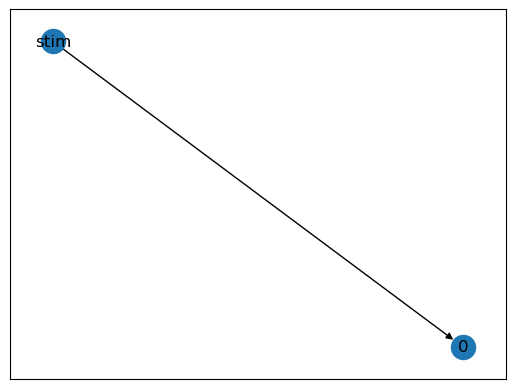

In [20]:
m.draw_model(nim_all)

In [16]:
nim_all.networks[0].layers[0](data.stim).shape

torch.Size([362504, 11])

<Figure size 640x480 with 0 Axes>

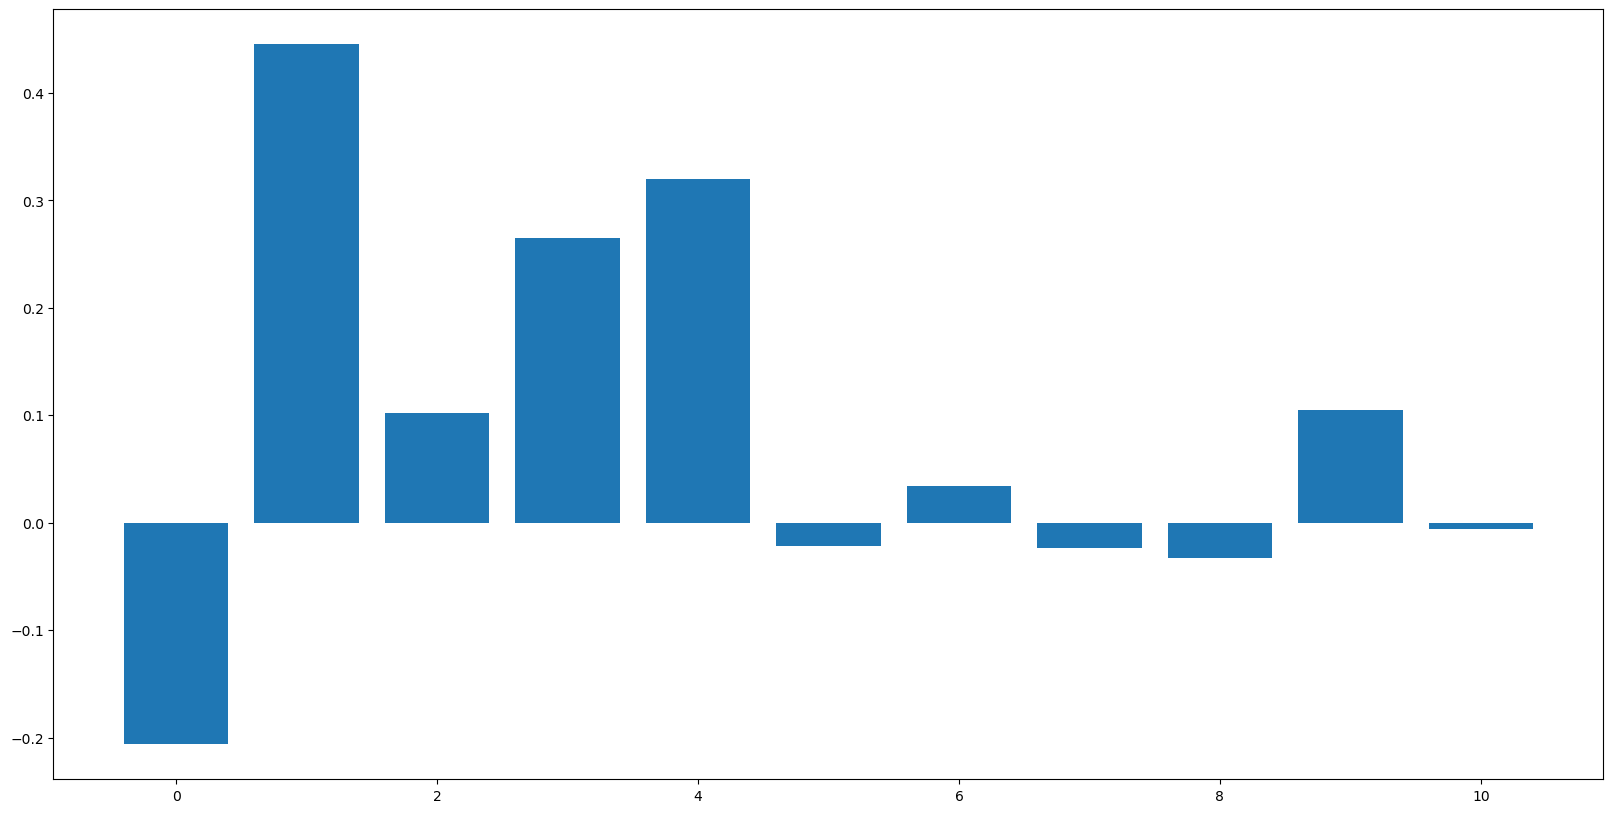

In [26]:
# R2
m.fig()
plt.bar(range(11), met.r2(data, nim_all))
plt.show()

## shared convolutional NIM

In [12]:
num_subs = 8
fw = 21
XTreg0 = 0.01
L1reg0 = 0.0001
Greg = 0.001
# subunit layer
csub_par = ConvLayer.layer_dict(
    input_dims=data.stim_dims, num_filters=num_subs, norm_type=1,
    num_inh=num_subs//2, filter_dims=fw, window='hamming',
    NLtype='relu', bias=False, initialize_center = True)
csub_par['reg_vals'] = {'d2xt': XTreg0, 'l1':L1reg0, 'center':Greg, 'bcs':{'d2xt':1}  }

# 'readout' layer
readout_par = NDNLayer.layer_dict(
    num_filters=data.NC, norm_type=0,
    NLtype='softplus', bias=True,
    pos_constraint=True,
    initialize_center = True)
readout_par['reg_vals'] = {'glocalx': Greg  }
cnim_all = NDN.NDN( layer_list=[csub_par, readout_par] )
cnim_all.list_parameters()

Network 0:
  Layer 0:
      weight: torch.Size([210, 8])
  Layer 1:
      weight: torch.Size([288, 11])
      bias: torch.Size([11])


In [13]:
cnim_all.fit_dl(train_ds, val_ds, **adam_pars, verbose=2)
LLs1 = cnim_all.eval_models(val_ds, null_adjusted=True)
print(LLs1, np.mean(LLs1))


GPU Available: True, GPU Used: True


Validating ver=1: 100%|██████████████████████████████████████████████████| 35/35 [00:00<00:00, 62.33it/s, val_loss=0.421]


Early stopping
Done fitting
  Fit complete: 79.98716759681702 sec elapsed


Eval models: 100%|██████████████████████████████████████████████████████████████████████| 69/69 [00:00<00:00, 110.64it/s]

[ 2.66808033e-01  5.84701240e-01  9.10861492e-01  2.63954520e-01
  3.82205009e-01  9.34419632e-02  1.15573645e-01  3.00343037e-02
 -2.86102295e-06  5.02227068e-01  2.46744871e-01] 0.3087772


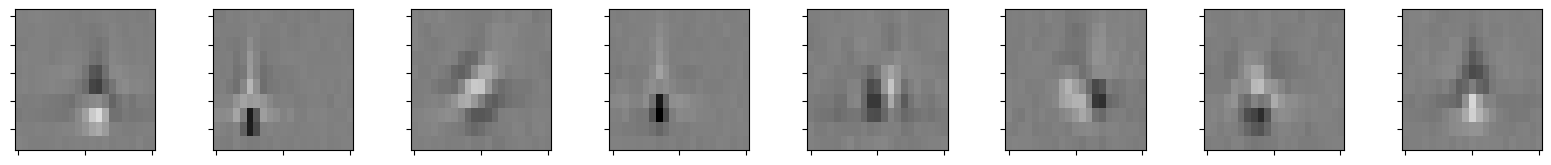

In [14]:
cnim_all.plot_filters()

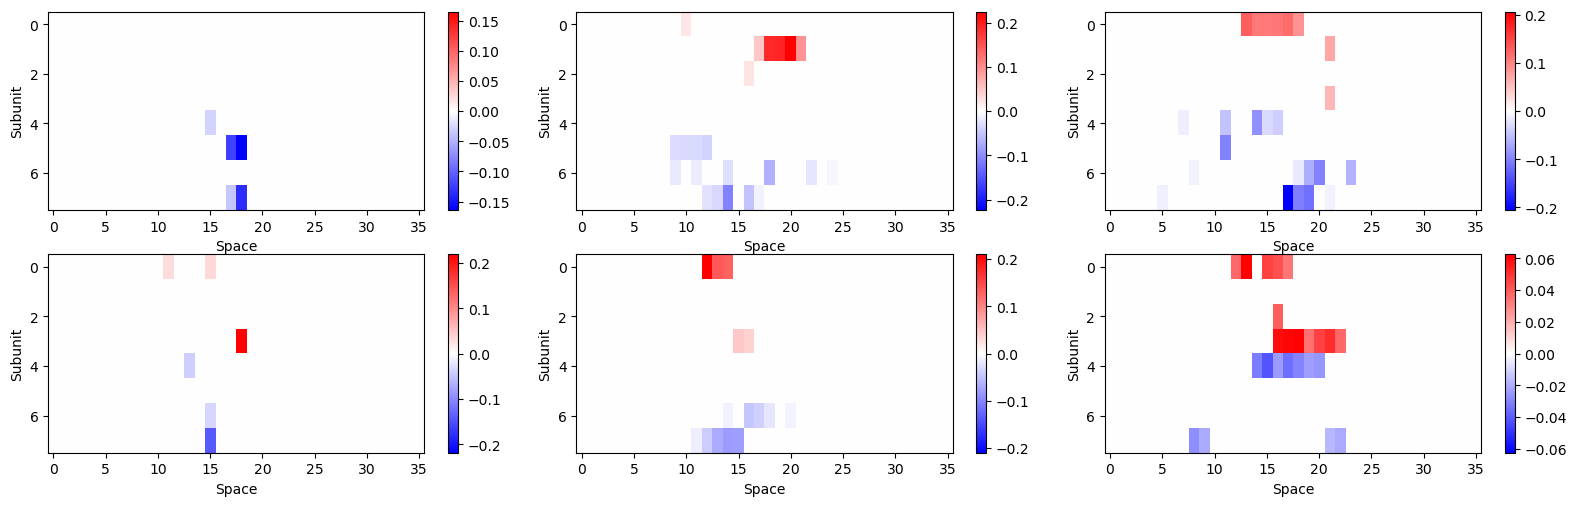

In [15]:
# Readout layer
wR = cnim_all.get_weights(layer_target=1)
wR.shape
# Make inhibitory weights less than zero
wR[num_subs//2:, :] *= -1
num_col = np.minimum(data.NC, 6)
ss(2, num_col//2)
for cc in range(num_col):
    plt.subplot(2, num_col//2, cc+1)
    imagesc(wR[:,:,cc].T, cmap='bwr')
    plt.ylabel('Subunit')
    plt.xlabel('Space')
    plt.colorbar()
plt.show()

<Figure size 640x480 with 0 Axes>

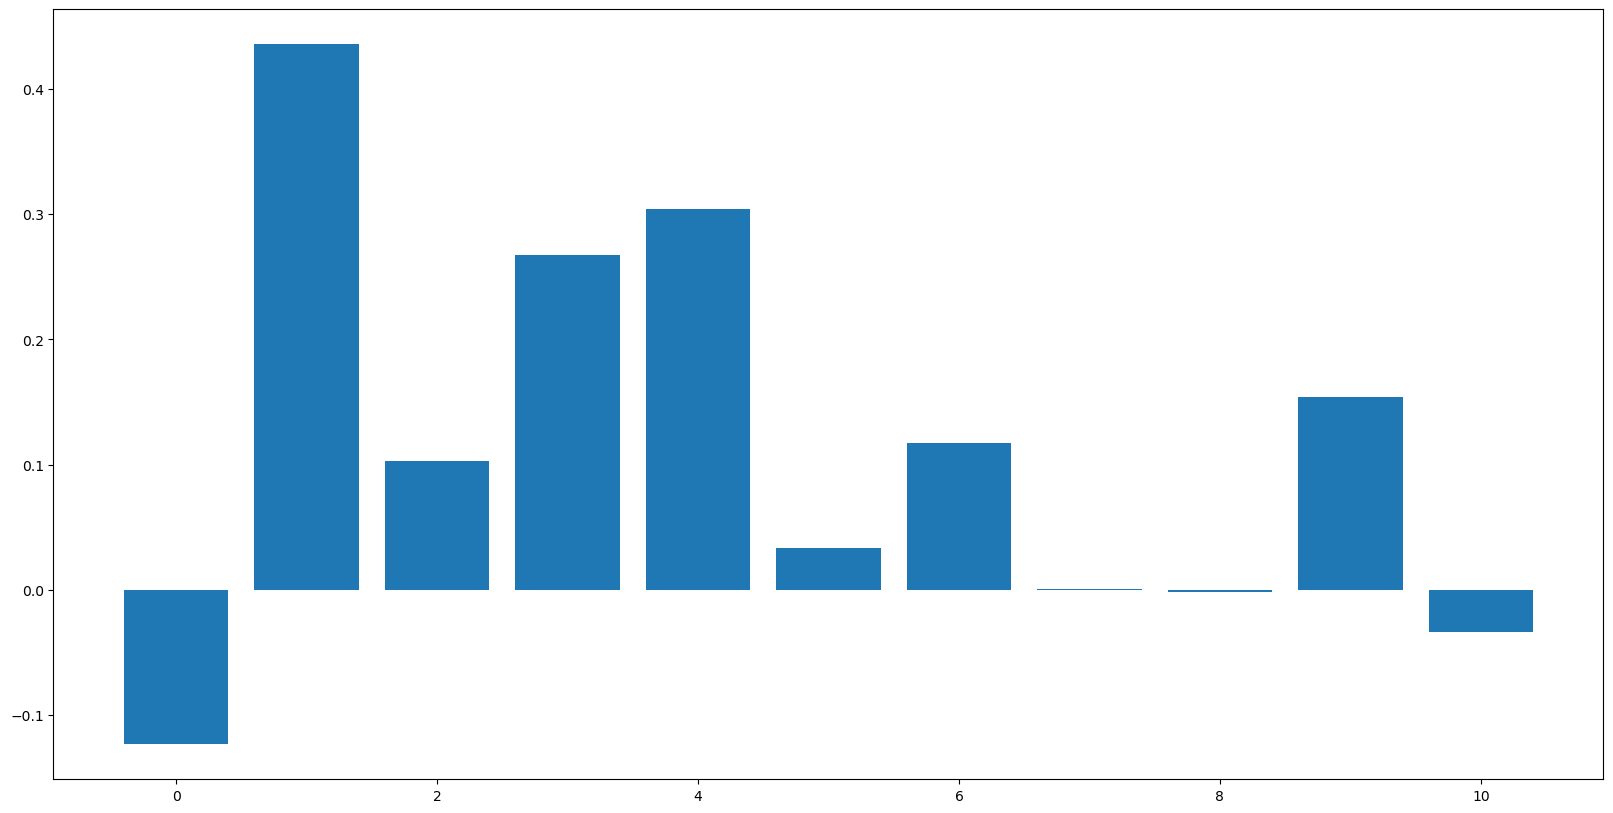

In [27]:
# R2
m.fig()
plt.bar(range(11), met.r2(data, cnim_all))
plt.show()